In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

In [2]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [3]:
df = pd.read_csv('../click_fraud_dataset.csv')

In [4]:
df.head()

,click_id,timestamp,user_id,ip_address,device_type,browser,operating_system,referrer_url,page_url,click_duration,...,mouse_movement,keystrokes_detected,ad_position,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score,is_fraudulent
0,d875835d-3a4a-4a20-b0d1-6cddf89afc6a,2024-08-23 02:47:39,65a2f621-707b-49be-9c3e-ccac0b1d89ef,141.36.49.37,Tablet,Safari,Android,https://evans-ford.com/,http://www.turner-stewart.com/,0.29,...,111,8,Bottom,7,72,Good,0,1,0.29,0
1,a2d3f028-7790-4be1-9f75-df1357edbbdb,2025-01-30 23:23:50,135e0114-76c5-43ea-bdef-80ab537dc009,216.29.19.201,Desktop,Opera,iOS,https://pierce-ferguson.net/,http://www.rodriguez.biz/,0.64,...,452,29,Bottom,9,201,Suspicious,0,0,0.74,0
2,36d787b2-fbce-43ef-8c02-7c8746d7e3db,2025-01-21 05:41:12,a6922984-78cb-4c01-9c88-bfe3a13a0aaf,167.133.41.231,Tablet,Safari,Linux,https://www.martinez.com/,https://beck.biz/,0.42,...,431,18,Bottom,9,326,Good,0,1,0.14,0
3,01fc0078-096b-4f90-82ae-aa8085b719ac,2024-10-12 08:18:14,d30788b2-4048-4770-a4b1-a9358788818f,216.146.33.78,Tablet,Edge,macOS,https://jones-mendoza.com/,https://www.alvarado.com/,4.29,...,472,37,Side,4,33,Suspicious,0,0,0.65,0
4,0afdf2af-0b48-47d5-bfb6-e087053e1eb9,2024-04-19 14:44:35,dfc42287-6325-4344-b373-b8e61ea6e5c1,146.37.54.245,Desktop,Opera,Windows,https://www.griffith-holloway.com/,http://gonzalez.com/,2.46,...,50,2,Side,7,97,Good,0,0,0.06,0


In [6]:
df.shape

(5000, 15)

Drop irrelevant columns

In [5]:
# Remove IDs, timestamps, and URLs (not useful for training)
drop_cols = [
    "click_id", "timestamp", "user_id", "referrer_url", "page_url", "ad_position"
]
df = df.drop(columns=drop_cols)

df.head()


,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score,is_fraudulent
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,Good,0,1,0.29,0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,Suspicious,0,0,0.74,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,Good,0,1,0.14,0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,Suspicious,0,0,0.65,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,Good,0,0,0.06,0


Select useful features + target

In [7]:
# Keep only the aligned features
useful_cols = [
    "click_duration",         # proxy for time per question
    "mouse_movement",         # mouse activity
    "keystrokes_detected",    # keystrokes dynamics
    "device_type",            # device info
    "browser",                # browser info
    "operating_system",       # OS info
    "ip_address",             # for anomaly detection
    "VPN_usage",              # VPN flag
    "proxy_usage",            # proxy flag
    "device_ip_reputation",   # IP reputation
    "is_fraudulent"           # target variable
]

df = df[useful_cols]
df.head()


,click_duration,mouse_movement,keystrokes_detected,device_type,browser,operating_system,ip_address,VPN_usage,proxy_usage,device_ip_reputation,is_fraudulent
0,0.29,111,8,Tablet,Safari,Android,141.36.49.37,0,1,Good,0
1,0.64,452,29,Desktop,Opera,iOS,216.29.19.201,0,0,Suspicious,0
2,0.42,431,18,Tablet,Safari,Linux,167.133.41.231,0,1,Good,0
3,4.29,472,37,Tablet,Edge,macOS,216.146.33.78,0,0,Suspicious,0
4,2.46,50,2,Desktop,Opera,Windows,146.37.54.245,0,0,Good,0


Encode categorical features

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
label_encoders = {}
for col in ["device_type", "browser", "operating_system", "device_ip_reputation", "ip_address"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()


,click_duration,mouse_movement,keystrokes_detected,device_type,browser,operating_system,ip_address,VPN_usage,proxy_usage,device_ip_reputation,is_fraudulent
0,0.29,111,8,2,4,0,1037,0,1,1,0
1,0.64,452,29,0,3,3,2928,0,0,2,0
2,0.42,431,18,2,4,1,1683,0,1,1,0
3,4.29,472,37,2,1,4,2920,0,0,2,0
4,2.46,50,2,0,3,2,1167,0,0,1,0


Split into Features (X) and Target (y)

In [21]:
# Separate features and target
x = df.drop(columns=["is_fraudulent"])
y = df["is_fraudulent"]



Scale numerical features

In [22]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Select only numerical columns to scale
numeric_cols = ["click_duration", "mouse_movement", "keystrokes_detected"]

x[numeric_cols] = scaler.fit_transform(x[numeric_cols])

x.head()


,click_duration,mouse_movement,keystrokes_detected,device_type,browser,operating_system,ip_address,VPN_usage,proxy_usage,device_ip_reputation
0,-0.866694,-0.956623,-1.167139,2,4,0,1037,0,1,1
1,-0.689967,1.381681,0.298029,0,3,3,2928,0,0,2
2,-0.801053,1.237680,-0.469440,2,4,1,1683,0,1,1
3,1.153050,1.518825,0.856189,2,1,4,2920,0,0,2
4,0.229017,-1.374912,-1.585759,0,3,2,1167,0,0,1


### Divide Dataset

In [27]:
from sklearn.model_selection import train_test_split

# Train/Test split (80/20) with stratification
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

In [29]:
y_train.value_counts()

is_fraudulent
0    3007
1     993
Name: count, dtype: int64

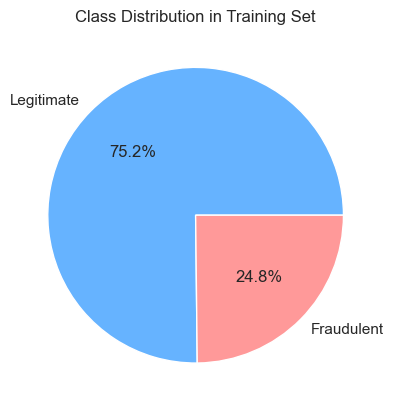

In [30]:
plt.pie(y_train.value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Class Distribution in Training Set')
plt.show()

### Handle Imbalanced Dataset

In [32]:
!pip install imbalanced-learn

In [34]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print(x_train_smote.shape, y_train_smote.shape)

(6014, 10) (6014,)


In [36]:
y_train_smote.value_counts()

is_fraudulent
1    3007
0    3007
Name: count, dtype: int64

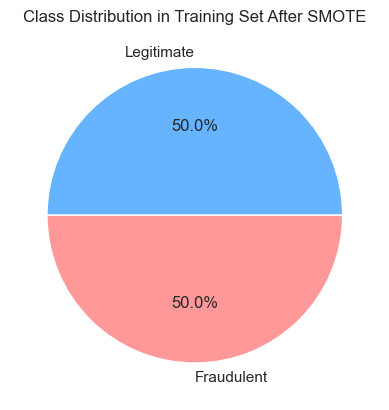

In [37]:
plt.pie(y_train_smote.value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Class Distribution in Training Set After SMOTE')
plt.show()

### Supervised Model Training and Evaluation

In [39]:
!pip install xgboost

In [59]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

Evaluation Function

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    prec = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores:\n\tAccuracy: {acc}\n\tPrecision: {prec}\n\tRecall: {rec}\n\tF1-Score: {f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    prec = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores:\n\tAccuracy: {acc}\n\tPrecision: {prec}\n\tRecall: {rec}\n\tF1-Score: {f1}')


#### Logistic Regression

In [61]:
lr = LogisticRegression()
lr.fit(x_train_smote, y_train_smote)

y_train_pred = lr.predict(x_train_smote)

y_test_pred = lr.predict(x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy: 0.641
	Precision: 0.623
	Recall: 0.713
	F1-Score: 0.665
Testing Scores:
	Accuracy: 0.52
	Precision: 0.246
	Recall: 0.452
	F1-Score: 0.318


#### Decision Tree

In [62]:
dt = DecisionTreeClassifier()
dt.fit(x_train_smote, y_train_smote)

y_train_pred = dt.predict(x_train_smote)

y_test_pred = dt.predict(x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0
Testing Scores:
	Accuracy: 0.576
	Precision: 0.254
	Recall: 0.367
	F1-Score: 0.3


#### Random Forest

In [63]:
rf = RandomForestClassifier()
rf.fit(x_train_smote, y_train_smote)

y_train_pred = rf.predict(x_train_smote)

y_test_pred = rf.predict(x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0
Testing Scores:
	Accuracy: 0.606
	Precision: 0.234
	Recall: 0.258
	F1-Score: 0.245


#### SVM

In [64]:
svc = SVC()
svc.fit(x_train_smote, y_train_smote)

y_train_pred = svc.predict(x_train_smote)

y_test_pred = svc.predict(x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy: 0.526
	Precision: 0.524
	Recall: 0.571
	F1-Score: 0.546
Testing Scores:
	Accuracy: 0.521
	Precision: 0.28
	Recall: 0.593
	F1-Score: 0.38


#### XGBoost

In [65]:
xgb = XGBClassifier()
xgb.fit(x_train_smote, y_train_smote)

y_train_pred = xgb.predict(x_train_smote)

y_test_pred = xgb.predict(x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy: 0.951
	Precision: 0.956
	Recall: 0.945
	F1-Score: 0.951
Testing Scores:
	Accuracy: 0.639
	Precision: 0.258
	Recall: 0.242
	F1-Score: 0.249
